<a href="https://colab.research.google.com/github/rdiazg14/ProductividadEmpleados/blob/main/GarmentsWorkerProductivity_RD_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import matplotlib.lines as lines
from IPython.display import HTML
import dateutil.parser as dt_parse
from scipy import stats
from scipy.special import inv_boxcox

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from xgboost import XGBRegressor

In [2]:
#Visualization settings
sns.set_style(style='white')
sns.set(rc={
    'figure.figsize': (12,7),
    'axes.facecolor': 'white',
    'axes.grid': True,
    'grid.color': '.9',
    'axes.linewidth': 1.0,
    'grid.linestyle': u'-'},
    font_scale=1.5)
custom_colors=["#3498db", "#95a5a6","#34495e", "#2ecc71", "#e74c3c"]
sns.set_palette(custom_colors)
background_color='#fbfbfb'

In [4]:
!wget -O garments_worker_productivity.csv https://archive.ics.uci.edu/ml/machine-learning-databases/00597/garments_worker_productivity.csv

--2021-07-01 05:22:36--  https://archive.ics.uci.edu/ml/machine-learning-databases/00597/garments_worker_productivity.csv
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94933 (93K) [application/x-httpd-php]
Saving to: ‘garments_worker_productivity.csv’

garments_worker_pro 100%[===================>]  92.71K   238KB/s    in 0.4s    

2021-07-01 05:22:37 (238 KB/s) - ‘garments_worker_productivity.csv’ saved [94933/94933]



In [5]:
# Load input data file
# RD GIT. 1.2 Configuración del DATASET y lectura inicial
#Lectura del dataset
file_name = "garments_worker_productivity.csv"

#El método "read_csv" nos permite leer un excel
df_input = pd.read_csv(file_name)

In [6]:
print (f"Shape of dataframe : {df_input.shape}\n")
print (f"Sample data frame:\n")
display(df_input.head())
print ("Dataset summary \n")
display (df_input.info())

Shape of dataframe : (1197, 15)

Sample data frame:



,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
0,1/1/2015,Quarter1,sweing,Thursday,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,0.940725
1,1/1/2015,Quarter1,finishing,Thursday,1,0.75,3.94,NaN,960,0,0.0,0,0,8.0,0.886500
2,1/1/2015,Quarter1,sweing,Thursday,11,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
3,1/1/2015,Quarter1,sweing,Thursday,12,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
4,1/1/2015,Quarter1,sweing,Thursday,6,0.80,25.90,1170.0,1920,50,0.0,0,0,56.0,0.800382


Dataset summary 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   1197 non-null   object 
 1   quarter                1197 non-null   object 
 2   department             1197 non-null   object 
 3   day                    1197 non-null   object 
 4   team                   1197 non-null   int64  
 5   targeted_productivity  1197 non-null   float64
 6   smv                    1197 non-null   float64
 7   wip                    691 non-null    float64
 8   over_time              1197 non-null   int64  
 9   incentive              1197 non-null   int64  
 10  idle_time              1197 non-null   float64
 11  idle_men               1197 non-null   int64  
 12  no_of_style_change     1197 non-null   int64  
 13  no_of_workers          1197 non-null   float64
 14  actual_productivity    1197 non-null  

None

In [7]:
# Missing values
missing_val= df_input.isnull().sum()
missing_val.sort_values(inplace=True, ascending=False)
print ("Missing value counts:\n")
display (missing_val)

Missing value counts:



wip                      506
actual_productivity        0
no_of_workers              0
no_of_style_change         0
idle_men                   0
idle_time                  0
incentive                  0
over_time                  0
smv                        0
targeted_productivity      0
team                       0
day                        0
department                 0
quarter                    0
date                       0
dtype: int64

**Feature Analysis**

In [8]:
#Discrete feature analysis
def analyze_discrete_feature(fld,display_graph=True):
    print ("Sample data:\n")
    display(fld.head())
    df=pd.DataFrame({"Value": fld.value_counts().index,
                 "Count":fld.value_counts().values})
    print ("\nNull value count : ", fld.isnull().sum())
    unique_list=fld.unique().tolist()
    print ("\nUnique values: ", unique_list)
    print ("\n Unique values count: ", len(unique_list))
    print ("\nValue counts:\n",    df)
    if display_graph==True:
        plt.subplots(figsize=(25,10),facecolor=background_color)
        plt.subplot(2,2,1)
        plt.pie(fld.value_counts(),labels=fld.value_counts().index,autopct=lambda x: f'{x: .2f}%');
        plt.xticks(rotation=90)

        plt.subplot(2,2,2)   
        sns.barplot(data=df, x="Value",y="Count").set_facecolor(background_color);
        plt.xticks(rotation=90);
        plt.suptitle(fld.name + " -distribution");

        plt.show()
        plt.close()
    display(HTML("<h4 style='background-color:#fbfbfb;font-family:serif;font-size:160%'>Discrete variable</h4>"))


In [9]:
#Continuous feature analysis
def analyze_continuous_feature(fld):
    print ("Sample data:\n",fld.head())
    print ("\nNull value count : ", fld.isnull().sum())
    print ("\n", fld.describe())
    print (f"\n Skewness : {fld.skew()} \n")
    plt.subplots(figsize=(25,10))
    plt.subplot(2,2,1)
    plt.hist(fld)
    plt.subplot(2,2,2)
    sns.boxplot(fld)
    plt.suptitle(fld.name + "-distribution")
    plt.show()
    plt.close()
    display(HTML("<h4 style='background-color:#fbfbfb;font-family:serif;font-size:160%'>Continuous variable</h4>"))

***1. Date***

In [10]:
df_input.date

0        1/1/2015
1        1/1/2015
2        1/1/2015
3        1/1/2015
4        1/1/2015
          ...    
1192    3/11/2015
1193    3/11/2015
1194    3/11/2015
1195    3/11/2015
1196    3/11/2015
Name: date, Length: 1197, dtype: object

Sample data:



0    Thursday
1    Thursday
2    Thursday
3    Thursday
4    Thursday
Name: day, dtype: object


Null value count :  0

Unique values:  ['Thursday', 'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday']

 Unique values count:  6

Value counts:
        Value  Count
0  Wednesday    208
1     Sunday    203
2    Tuesday    201
3     Monday    199
4   Thursday    199
5   Saturday    187


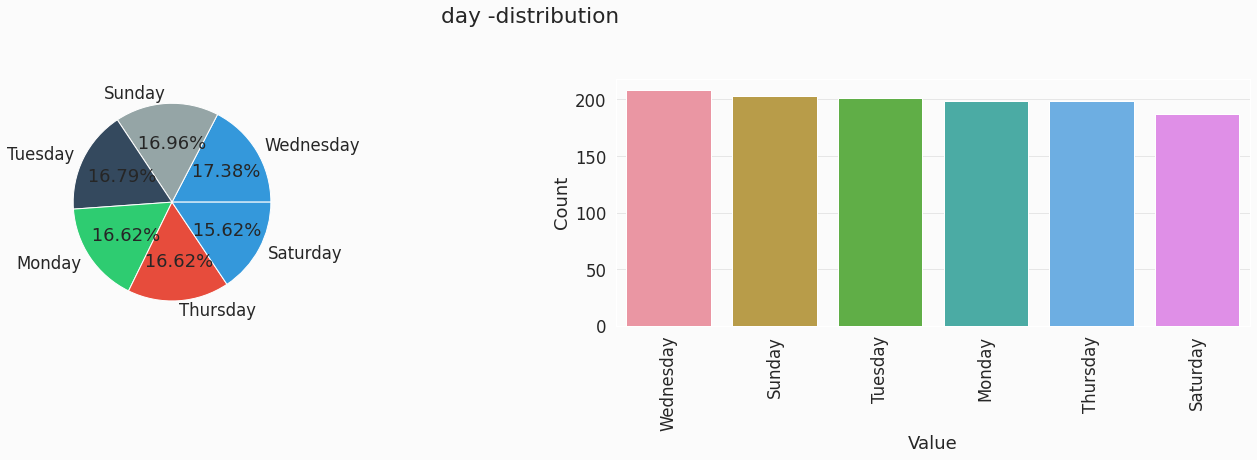

In [11]:
analyze_discrete_feature(df_input.day)

Sample data:



0    Quarter1
1    Quarter1
2    Quarter1
3    Quarter1
4    Quarter1
Name: quarter, dtype: object


Null value count :  0

Unique values:  ['Quarter1', 'Quarter2', 'Quarter3', 'Quarter4', 'Quarter5']

 Unique values count:  5

Value counts:
       Value  Count
0  Quarter1    360
1  Quarter2    335
2  Quarter4    248
3  Quarter3    210
4  Quarter5     44


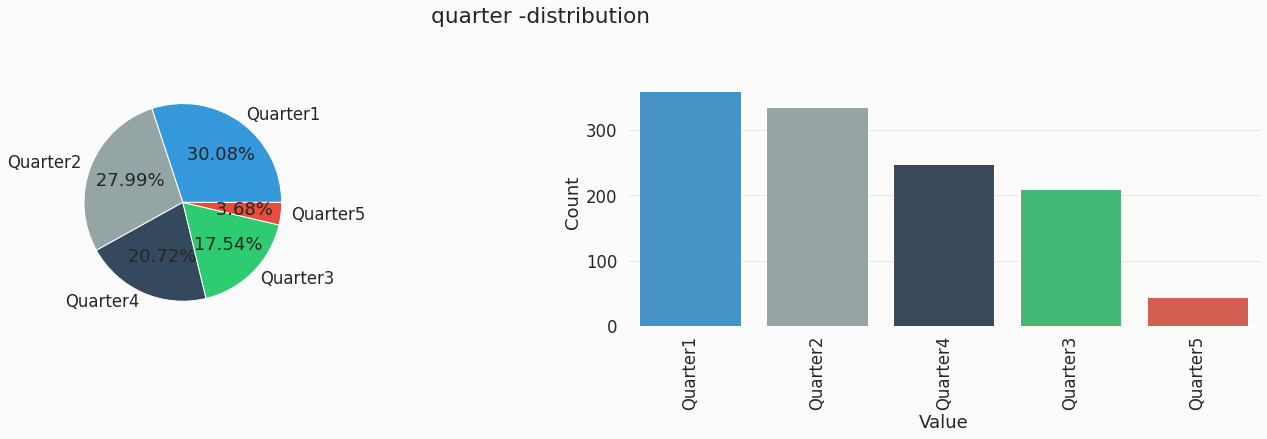

In [12]:
analyze_discrete_feature(df_input.quarter)

In [13]:
# Found that there are whitespaces in the department column.
# Trimming the white spaces
df_input['department'] = df_input['department'].apply(str.strip)

Sample data:



0       sweing
1    finishing
2       sweing
3       sweing
4       sweing
Name: department, dtype: object


Null value count :  0

Unique values:  ['sweing', 'finishing']

 Unique values count:  2

Value counts:
        Value  Count
0     sweing    691
1  finishing    506


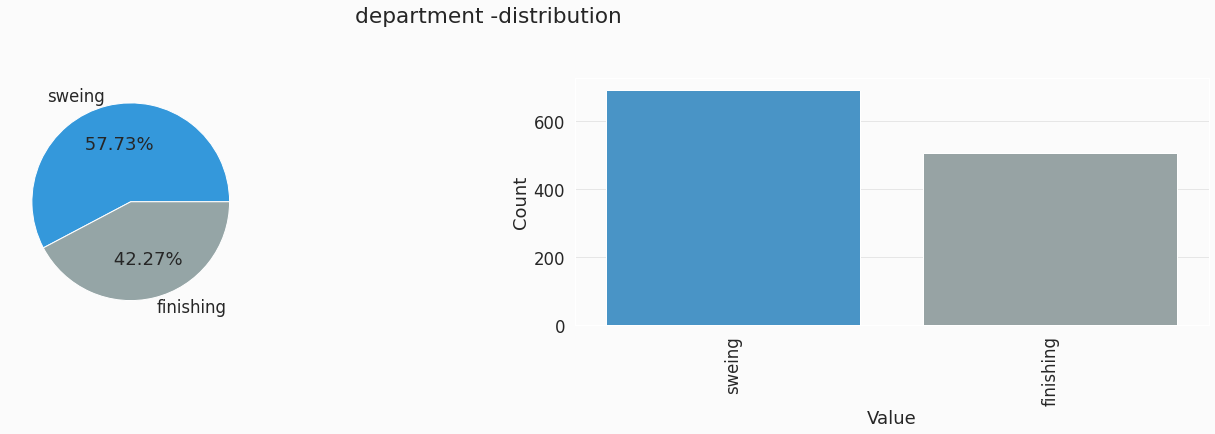

In [14]:
analyze_discrete_feature(df_input.department)

Sample data:



0     8
1     1
2    11
3    12
4     6
Name: team, dtype: int64


Null value count :  0

Unique values:  [8, 1, 11, 12, 6, 7, 2, 3, 9, 10, 5, 4]

 Unique values count:  12

Value counts:
     Value  Count
0       8    109
1       2    109
2       4    105
3       1    105
4       9    104
5      10    100
6      12     99
7       7     96
8       3     95
9       6     94
10      5     93
11     11     88


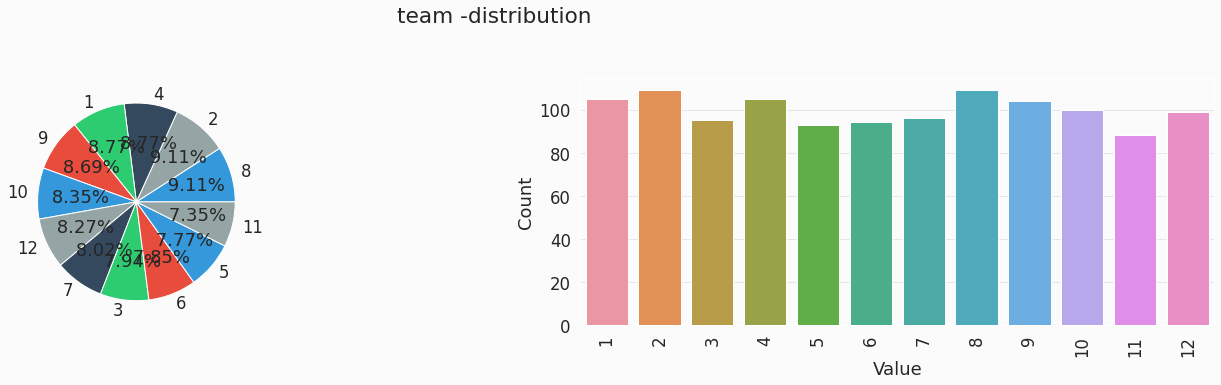

In [15]:
analyze_discrete_feature(df_input.team)

Sample data:
 0    59.0
1     8.0
2    30.5
3    30.5
4    56.0
Name: no_of_workers, dtype: float64

Null value count :  0

 count    1197.000000
mean       34.609858
std        22.197687
min         2.000000
25%         9.000000
50%        34.000000
75%        57.000000
max        89.000000
Name: no_of_workers, dtype: float64

 Skewness : -0.11173973121993644 



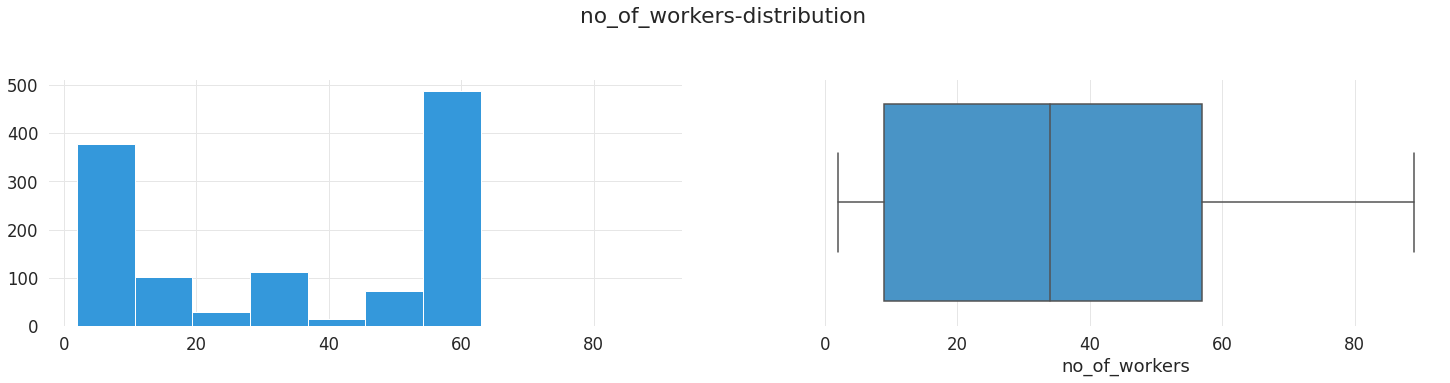

In [16]:
analyze_continuous_feature(df_input.no_of_workers)

Sample data:
 0    0
1    0
2    0
3    0
4    0
Name: no_of_style_change, dtype: int64

Null value count :  0

 count    1197.000000
mean        0.150376
std         0.427848
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         2.000000
Name: no_of_style_change, dtype: float64

 Skewness : 2.9425059460671514 



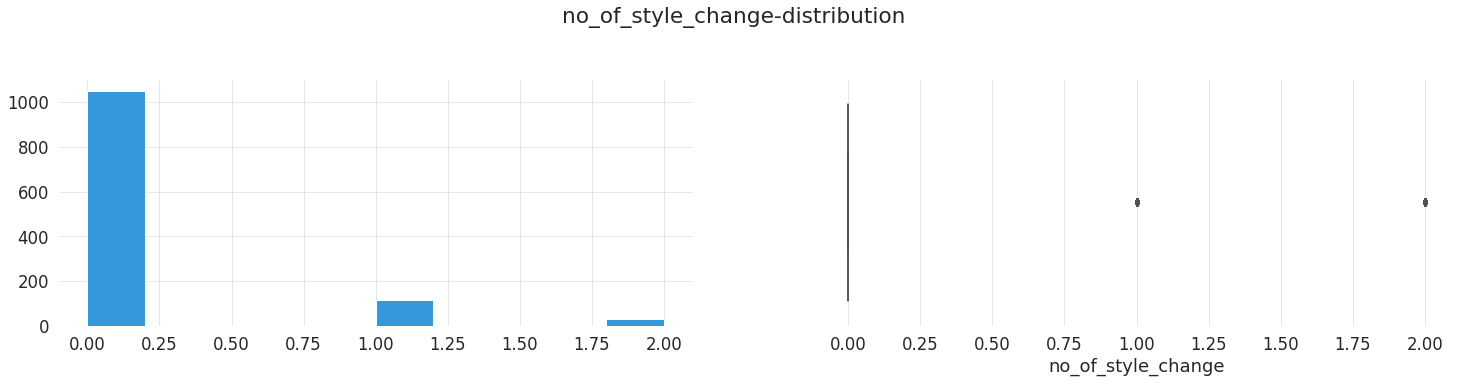

In [17]:
analyze_continuous_feature(df_input.no_of_style_change)

Sample data:
 0    0.80
1    0.75
2    0.80
3    0.80
4    0.80
Name: targeted_productivity, dtype: float64

Null value count :  0

 count    1197.000000
mean        0.729632
std         0.097891
min         0.070000
25%         0.700000
50%         0.750000
75%         0.800000
max         0.800000
Name: targeted_productivity, dtype: float64

 Skewness : -2.144150033252199 



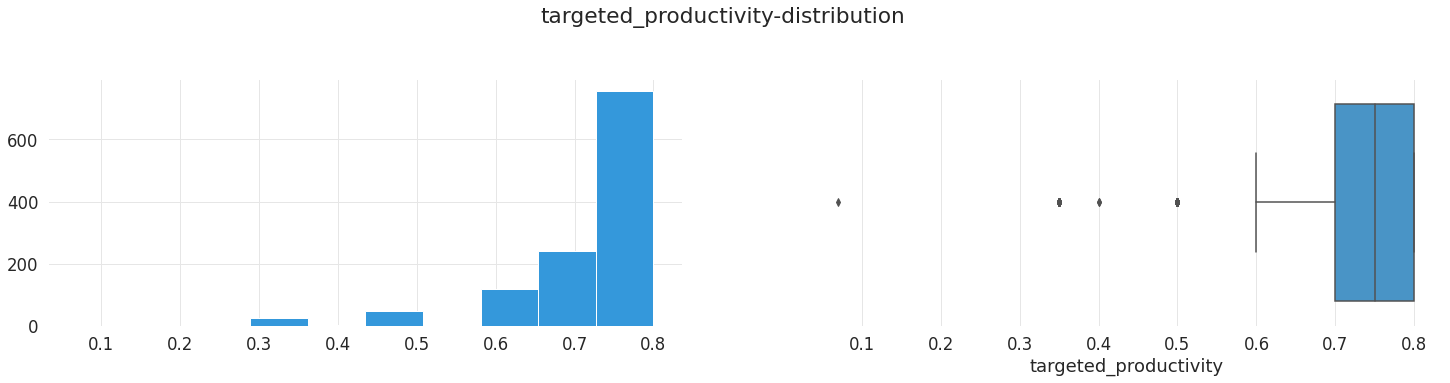

In [18]:
analyze_continuous_feature(df_input.targeted_productivity)

Sample data:
 0    26.16
1     3.94
2    11.41
3    11.41
4    25.90
Name: smv, dtype: float64

Null value count :  0

 count    1197.000000
mean       15.062172
std        10.943219
min         2.900000
25%         3.940000
50%        15.260000
75%        24.260000
max        54.560000
Name: smv, dtype: float64

 Skewness : 0.40593673685873205 



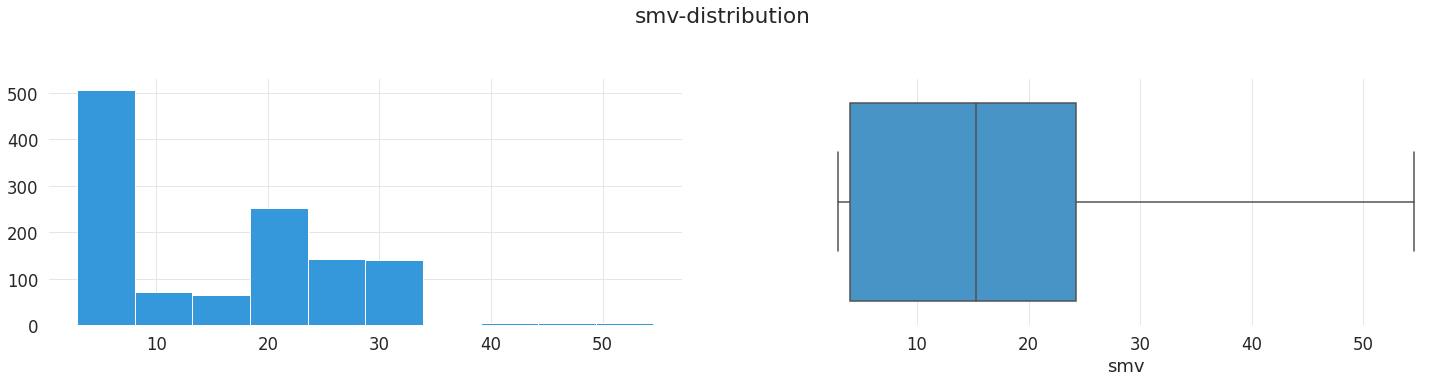

In [19]:
analyze_continuous_feature(df_input.smv)

Sample data:
 0    1108.0
1       NaN
2     968.0
3     968.0
4    1170.0
Name: wip, dtype: float64

Null value count :  506

 count      691.000000
mean      1190.465991
std       1837.455001
min          7.000000
25%        774.500000
50%       1039.000000
75%       1252.500000
max      23122.000000
Name: wip, dtype: float64

 Skewness : 9.741786273952965 



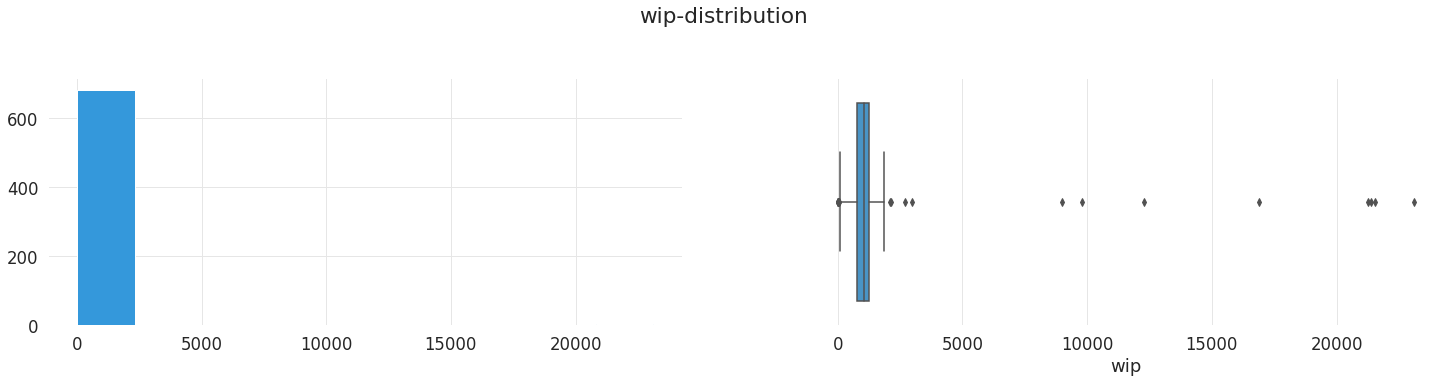

In [20]:
analyze_continuous_feature(df_input.wip)

Sample data:
 0    7080
1     960
2    3660
3    3660
4    1920
Name: over_time, dtype: int64

Null value count :  0

 count     1197.000000
mean      4567.460317
std       3348.823563
min          0.000000
25%       1440.000000
50%       3960.000000
75%       6960.000000
max      25920.000000
Name: over_time, dtype: float64

 Skewness : 0.6732872952976457 



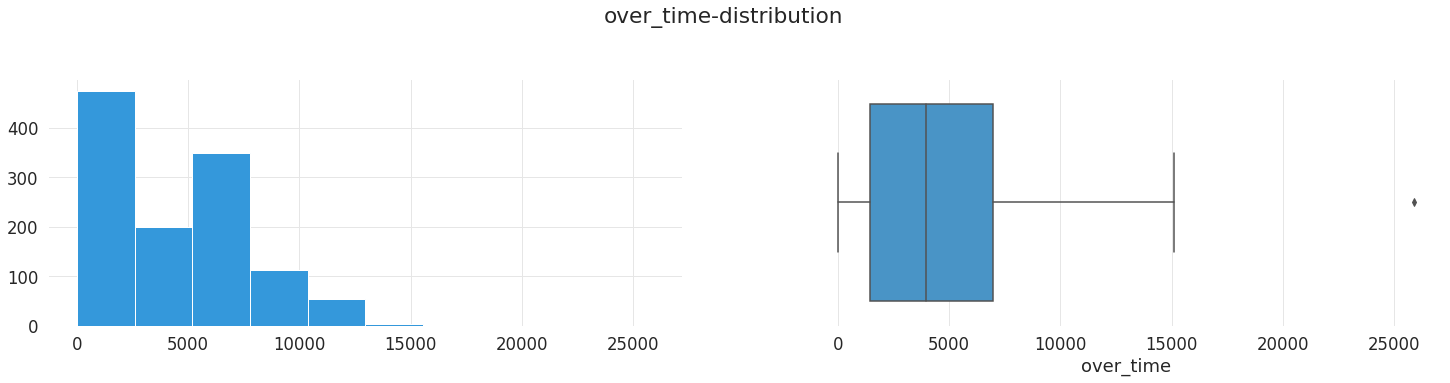

In [21]:
analyze_continuous_feature(df_input.over_time)

Sample data:
 0    98
1     0
2    50
3    50
4    50
Name: incentive, dtype: int64

Null value count :  0

 count    1197.000000
mean       38.210526
std       160.182643
min         0.000000
25%         0.000000
50%         0.000000
75%        50.000000
max      3600.000000
Name: incentive, dtype: float64

 Skewness : 15.790746016958247 



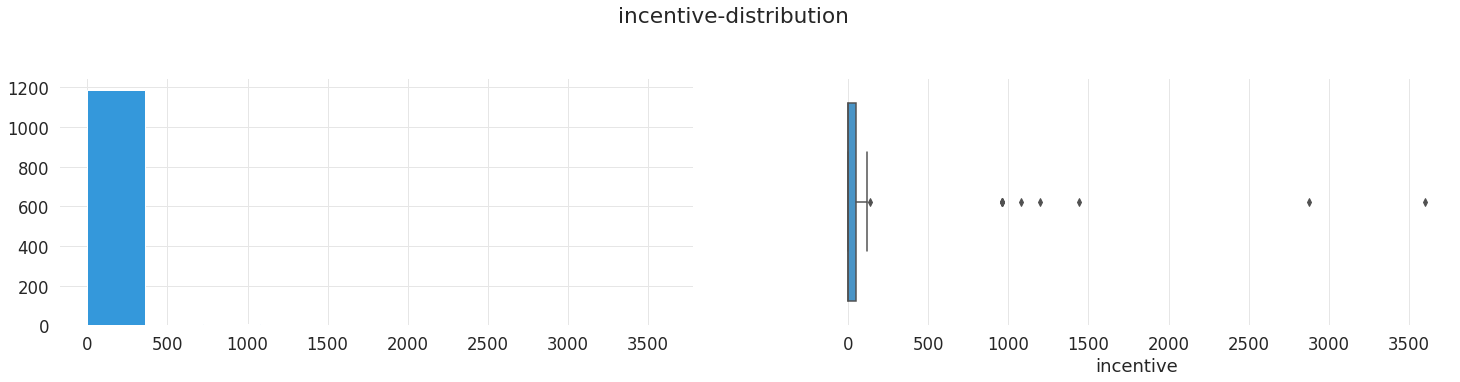

In [22]:
analyze_continuous_feature(df_input.incentive)

Sample data:
 0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: idle_time, dtype: float64

Null value count :  0

 count    1197.000000
mean        0.730159
std        12.709757
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       300.000000
Name: idle_time, dtype: float64

 Skewness : 20.545425229670172 



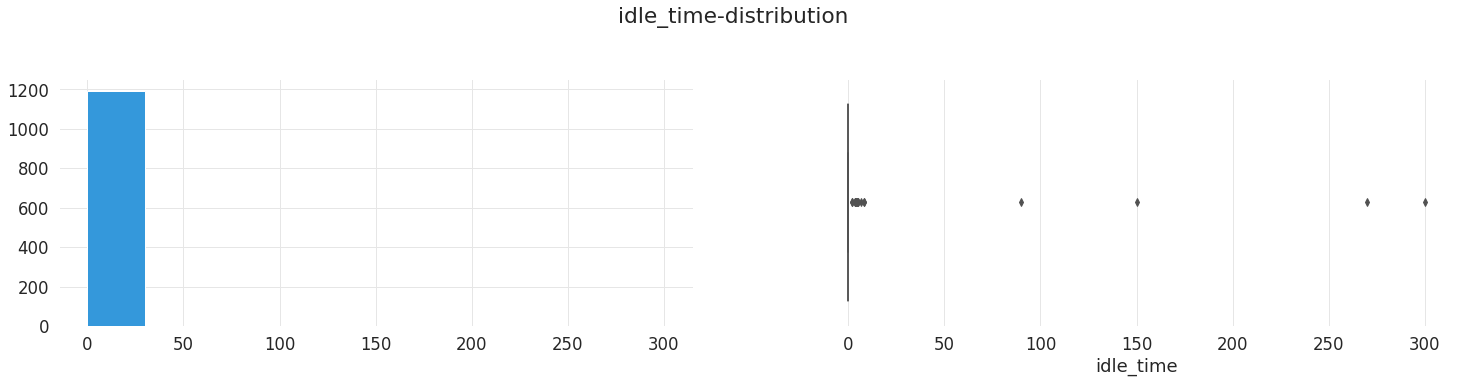

In [23]:
analyze_continuous_feature(df_input.idle_time)

Sample data:
 0    0
1    0
2    0
3    0
4    0
Name: idle_men, dtype: int64

Null value count :  0

 count    1197.000000
mean        0.369256
std         3.268987
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        45.000000
Name: idle_men, dtype: float64

 Skewness : 9.855079123524012 



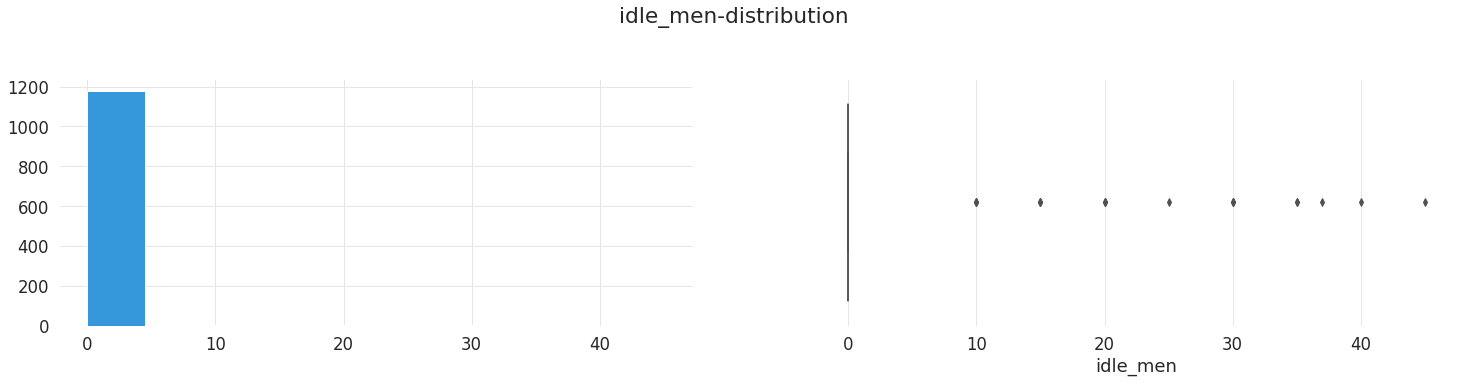

In [24]:
analyze_continuous_feature(df_input.idle_men)

Sample data:
 0    0.940725
1    0.886500
2    0.800570
3    0.800570
4    0.800382
Name: actual_productivity, dtype: float64

Null value count :  0

 count    1197.000000
mean        0.735091
std         0.174488
min         0.233705
25%         0.650307
50%         0.773333
75%         0.850253
max         1.120437
Name: actual_productivity, dtype: float64

 Skewness : -0.8074917745097576 



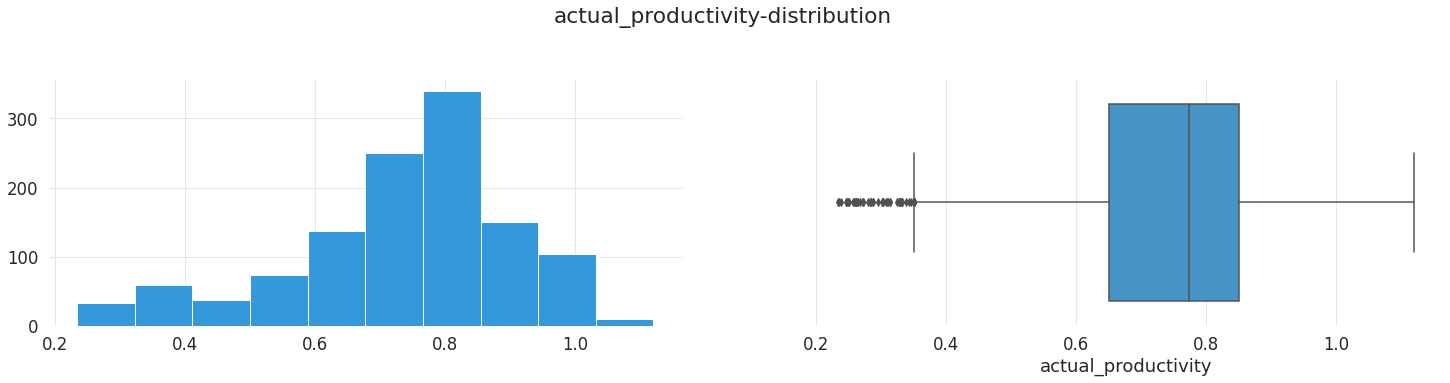

In [25]:
analyze_continuous_feature(df_input.actual_productivity)

# **Feature Relationships**

In [26]:
#Change the string formatted date column to datetime object
df_input['date_dt'] = df_input['date'].apply(lambda x : dt_parse.parse(x))

df_input['date'] = df_input.date_dt.apply(lambda x : x.day)
df_input['month'] = df_input.date_dt.apply(lambda x : x.month)
df_input['year'] = df_input.date_dt.apply(lambda x : x.year)

# Remove the existing date feature
df_input.drop('date_dt',axis=1, inplace=True)

print (f'years:{df_input.year.unique()}')
print (f'months:{df_input.month.unique()}')

years:[2015]
months:[1 2 3]


In [27]:
df_input

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity,month,year
0,1,Quarter1,sweing,Thursday,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,0.940725,1,2015
1,1,Quarter1,finishing,Thursday,1,0.75,3.94,NaN,960,0,0.0,0,0,8.0,0.886500,1,2015
2,1,Quarter1,sweing,Thursday,11,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570,1,2015
3,1,Quarter1,sweing,Thursday,12,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570,1,2015
4,1,Quarter1,sweing,Thursday,6,0.80,25.90,1170.0,1920,50,0.0,0,0,56.0,0.800382,1,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1192,11,Quarter2,finishing,Wednesday,10,0.75,2.90,NaN,960,0,0.0,0,0,8.0,0.628333,3,2015
1193,11,Quarter2,finishing,Wednesday,8,0.70,3.90,NaN,960,0,0.0,0,0,8.0,0.625625,3,2015
1194,11,Quarter2,finishing,Wednesday,7,0.65,3.90,NaN,960,0,0.0,0,0,8.0,0.625625,3,2015
1195,11,Quarter2,finishing,Wednesday,9,0.75,2.90,NaN,1800,0,0.0,0,0,15.0,0.505889,3,2015


In [28]:
summary=df_input.groupby('department').agg('sum')['actual_productivity']

department
finishing    380.993038
sweing       498.911005
Name: actual_productivity, dtype: float64


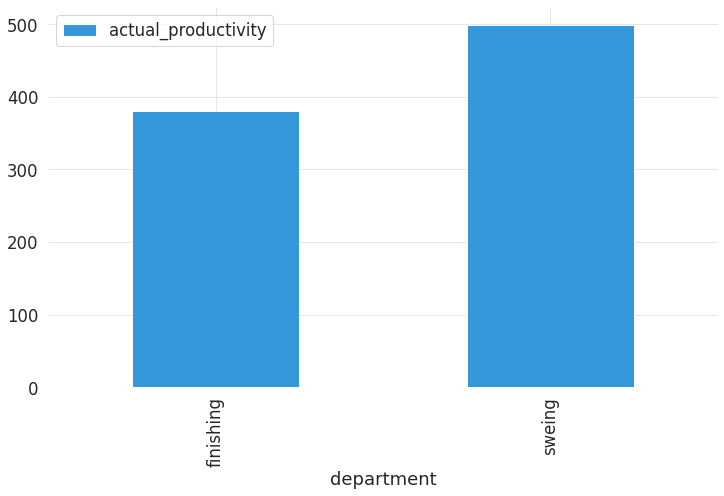

In [29]:
print (summary)
summary.to_frame().plot.bar()

In [30]:
summary = summary.to_frame()
display (summary)

,actual_productivity
department,
finishing,380.993038
sweing,498.911005


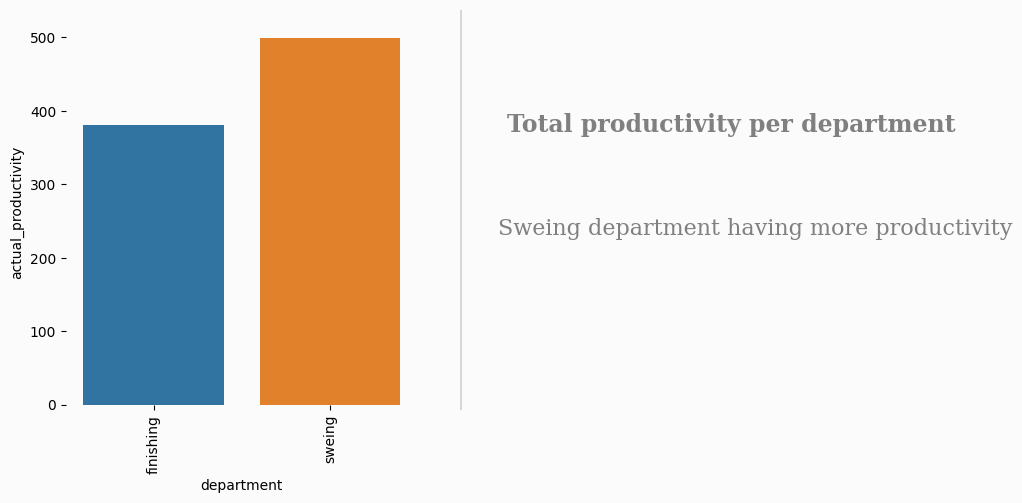

In [31]:
sns.reset_defaults()

#Visualization
fig=plt.figure(figsize=(10,5));

ax0=fig.add_subplot(1,2,1)
ax1=fig.add_subplot(1,2,2)
ax1.grid(False)
ax1.set_xticklabels([])
ax1.set_yticklabels([])

fig.patch.set_facecolor(background_color)
ax0.set_facecolor(background_color)
ax1.set_facecolor(background_color)
ax0.spines["bottom"].set_visible(False)
ax0.spines["top"].set_visible(False)
ax0.spines["right"].set_visible(False)
ax0.spines["left"].set_visible(False)
ax1.spines["bottom"].set_visible(False)
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.spines["left"].set_visible(False)
ax1.tick_params(left=False,bottom=False)

#Plot the barplot
sns.barplot(data=summary,x=summary.index,y=summary.actual_productivity,ax=ax0)

#rotating the ticklabels in x axis
for tick in ax0.get_xticklabels():
    tick.set_rotation(90)
    
#Draw line in the middle    
l1= lines.Line2D([0.52,0.52],[0.1, 0.9],color='black',lw=0.2,transform=fig.transFigure)
fig.lines.extend([l1])

#heading content
fig.text(x=0.5,
        y=0.6,
        fontweight='bold',
        fontfamily='serif',
        fontsize=17,
        color='grey',
        s='''
        Total productivity per department
        ''')
#text content
fig.text(x=0.5,
        y=0.4,
        fontweight='light',
        fontfamily='serif',
        fontsize=16,
        color='grey',
        s='''
        Sweing department having more productivity
        ''')
plt.show()

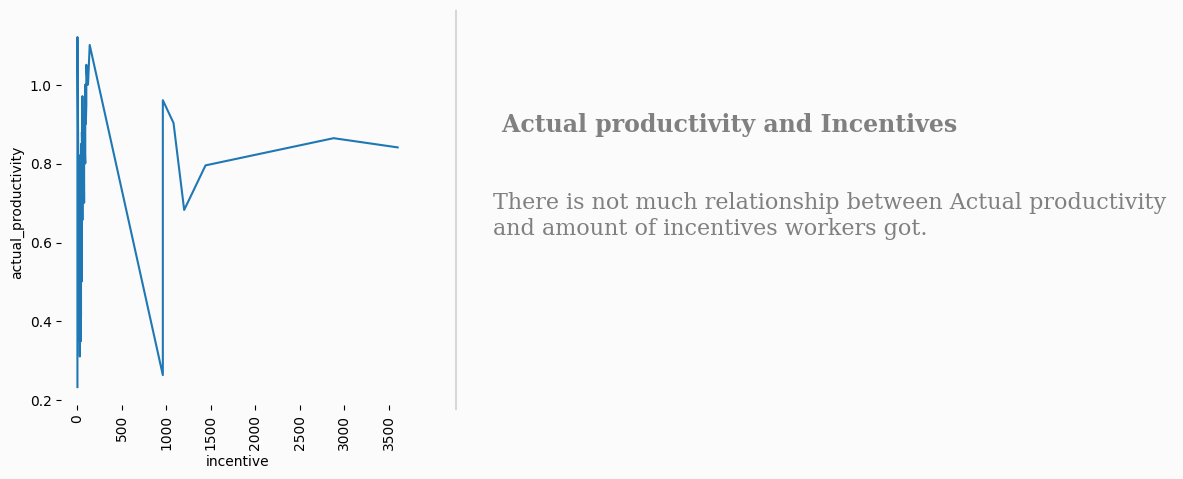

In [32]:
sns.reset_defaults()

#Visualization
fig=plt.figure(figsize=(10,5));

ax0=fig.add_subplot(1,2,1)
ax1=fig.add_subplot(1,2,2)
ax1.grid(False)
ax1.set_xticklabels([])
ax1.set_yticklabels([])

fig.patch.set_facecolor(background_color)
ax0.set_facecolor(background_color)
ax1.set_facecolor(background_color)
ax0.spines["bottom"].set_visible(False)
ax0.spines["top"].set_visible(False)
ax0.spines["right"].set_visible(False)
ax0.spines["left"].set_visible(False)
ax1.spines["bottom"].set_visible(False)
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.spines["left"].set_visible(False)
ax1.tick_params(left=False,bottom=False)

#Plot the barplot
sns.lineplot(data=df_input, x = 'incentive', y='actual_productivity',estimator=None,ax=ax0)

#rotating the ticklabels in x axis
for tick in ax0.get_xticklabels():
    tick.set_rotation(90)
    
#Draw line in the middle    
l1= lines.Line2D([0.52,0.52],[0.1, 0.9],color='black',lw=0.2,transform=fig.transFigure)
fig.lines.extend([l1])

#heading content
fig.text(x=0.5,
        y=0.6,
        fontweight='bold',
        fontfamily='serif',
        fontsize=17,
        color='grey',
        s='''
        Actual productivity and Incentives
        ''')
#text content
fig.text(x=0.5,
        y=0.4,
        fontweight='light',
        fontfamily='serif',
        fontsize=16,
        color='grey',
        s='''
        There is not much relationship between Actual productivity 
        and amount of incentives workers got.
        ''')
plt.show()

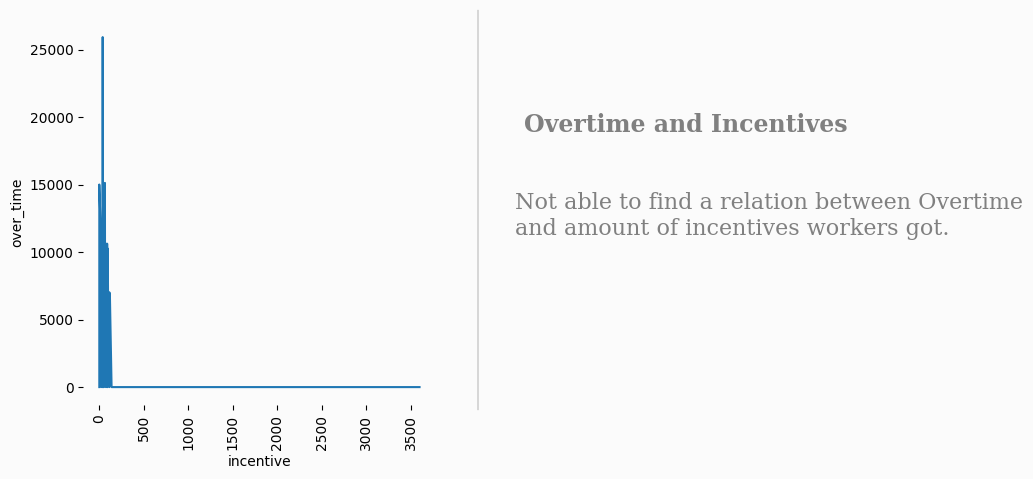

In [33]:
sns.reset_defaults()

#Visualization
fig=plt.figure(figsize=(10,5));

ax0=fig.add_subplot(1,2,1)
ax1=fig.add_subplot(1,2,2)
ax1.grid(False)
ax1.set_xticklabels([])
ax1.set_yticklabels([])

fig.patch.set_facecolor(background_color)
ax0.set_facecolor(background_color)
ax1.set_facecolor(background_color)
ax0.spines["bottom"].set_visible(False)
ax0.spines["top"].set_visible(False)
ax0.spines["right"].set_visible(False)
ax0.spines["left"].set_visible(False)
ax1.spines["bottom"].set_visible(False)
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.spines["left"].set_visible(False)
ax1.tick_params(left=False,bottom=False)

#Plot the barplot
sns.lineplot(data=df_input,x = 'incentive', y='over_time',estimator=None,ax=ax0)

#rotating the ticklabels in x axis
for tick in ax0.get_xticklabels():
    tick.set_rotation(90)
    
#Draw line in the middle    
l1= lines.Line2D([0.52,0.52],[0.1, 0.9],color='black',lw=0.2,transform=fig.transFigure)
fig.lines.extend([l1])

#heading content
fig.text(x=0.5,
        y=0.6,
        fontweight='bold',
        fontfamily='serif',
        fontsize=17,
        color='grey',
        s='''
        Overtime and Incentives
        ''')
#text content
fig.text(x=0.5,
        y=0.4,
        fontweight='light',
        fontfamily='serif',
        fontsize=16,
        color='grey',
        s='''
        Not able to find a relation between Overtime
        and amount of incentives workers got.
        ''')
plt.show()

In [34]:
df_input

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity,month,year
0,1,Quarter1,sweing,Thursday,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,0.940725,1,2015
1,1,Quarter1,finishing,Thursday,1,0.75,3.94,NaN,960,0,0.0,0,0,8.0,0.886500,1,2015
2,1,Quarter1,sweing,Thursday,11,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570,1,2015
3,1,Quarter1,sweing,Thursday,12,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570,1,2015
4,1,Quarter1,sweing,Thursday,6,0.80,25.90,1170.0,1920,50,0.0,0,0,56.0,0.800382,1,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1192,11,Quarter2,finishing,Wednesday,10,0.75,2.90,NaN,960,0,0.0,0,0,8.0,0.628333,3,2015
1193,11,Quarter2,finishing,Wednesday,8,0.70,3.90,NaN,960,0,0.0,0,0,8.0,0.625625,3,2015
1194,11,Quarter2,finishing,Wednesday,7,0.65,3.90,NaN,960,0,0.0,0,0,8.0,0.625625,3,2015
1195,11,Quarter2,finishing,Wednesday,9,0.75,2.90,NaN,1800,0,0.0,0,0,15.0,0.505889,3,2015


In [35]:
df_input.month.unique()

array([1, 2, 3])

In [36]:
df = df_input.groupby('month').agg({'targeted_productivity':'mean','actual_productivity':'mean'})

In [37]:
df.reset_index(inplace=True)

In [38]:
df

,month,targeted_productivity,actual_productivity
0,1,0.733487,0.755415
1,2,0.729729,0.717948
2,3,0.719575,0.718953


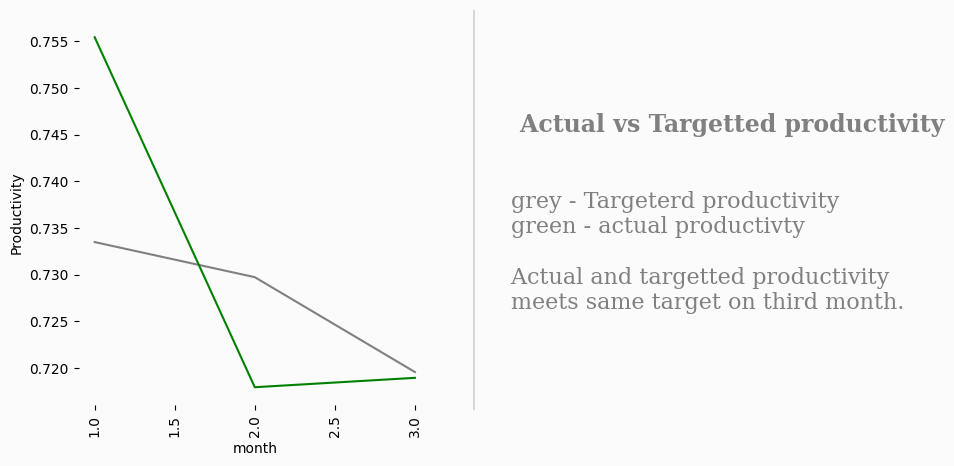

In [39]:
sns.reset_defaults()

#Visualization
fig=plt.figure(figsize=(10,5));

ax0=fig.add_subplot(1,2,1)
ax1=fig.add_subplot(1,2,2)
ax1.grid(False)
ax1.set_xticklabels([])
ax1.set_yticklabels([])

fig.patch.set_facecolor(background_color)
ax0.set_facecolor(background_color)
ax1.set_facecolor(background_color)
ax0.spines["bottom"].set_visible(False)
ax0.spines["top"].set_visible(False)
ax0.spines["right"].set_visible(False)
ax0.spines["left"].set_visible(False)
ax1.spines["bottom"].set_visible(False)
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.spines["left"].set_visible(False)
ax1.tick_params(left=False,bottom=False)

#Plot 
sns.lineplot(data=df,x='month',y='targeted_productivity',ax=ax0,color='grey')
sns.lineplot(data=df,x='month',y='actual_productivity',ax=ax0,color='green')
ax0.set_ylabel('Productivity')

#rotating the ticklabels in x axis
for tick in ax0.get_xticklabels():
    tick.set_rotation(90)
    
#Draw line in the middle    
l1= lines.Line2D([0.52,0.52],[0.1, 0.9],color='black',lw=0.2,transform=fig.transFigure)
fig.lines.extend([l1])

#heading content
fig.text(x=0.5,
        y=0.6,
        fontweight='bold',
        fontfamily='serif',
        fontsize=17,
        color='grey',
        s='''
        Actual vs Targetted productivity
        ''')
#text content
fig.text(x=0.5,
        y=0.2,
        fontweight='light',
        fontfamily='serif',
        fontsize=16,
        color='grey',
        s='''
        grey - Targeterd productivity
        green - actual productivty
        
        Actual and targetted productivity
        meets same target on third month.
        
        ''')
plt.show()

In [40]:
result=df_input.groupby(['month','team']).agg({'actual_productivity':'sum'})

In [41]:
type(result)

pandas.core.frame.DataFrame

In [42]:
result.reset_index(inplace=True)

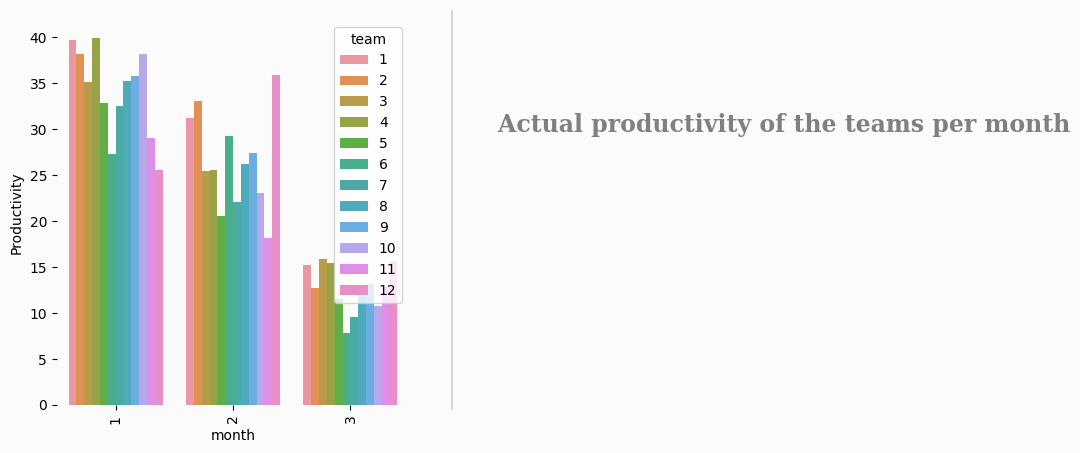

In [43]:
sns.reset_defaults()

#Visualization
fig=plt.figure(figsize=(10,5));

ax0=fig.add_subplot(1,2,1)
ax1=fig.add_subplot(1,2,2)
ax1.grid(False)
ax1.set_xticklabels([])
ax1.set_yticklabels([])

fig.patch.set_facecolor(background_color)
ax0.set_facecolor(background_color)
ax1.set_facecolor(background_color)
ax0.spines["bottom"].set_visible(False)
ax0.spines["top"].set_visible(False)
ax0.spines["right"].set_visible(False)
ax0.spines["left"].set_visible(False)
ax1.spines["bottom"].set_visible(False)
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.spines["left"].set_visible(False)
ax1.tick_params(left=False,bottom=False)

#Plot 
sns.barplot(data=result,x='month',y='actual_productivity',hue='team',ax=ax0)
ax0.set_ylabel('Productivity')

#rotating the ticklabels in x axis
for tick in ax0.get_xticklabels():
    tick.set_rotation(90)
    
#Draw line in the middle    
l1= lines.Line2D([0.52,0.52],[0.1, 0.9],color='black',lw=0.2,transform=fig.transFigure)
fig.lines.extend([l1])

#heading content
fig.text(x=0.5,
        y=0.6,
        fontweight='bold',
        fontfamily='serif',
        fontsize=17,
        color='grey',
        s='''
        Actual productivity of the teams per month
        ''')
#text content
fig.text(x=0.5,
        y=0.2,
        fontweight='light',
        fontfamily='serif',
        fontsize=16,
        color='grey',
        s='''
                
        ''')
plt.show()

In [44]:
result=df_input.groupby('day').agg({'actual_productivity':'mean'})
result.reset_index(inplace=True)

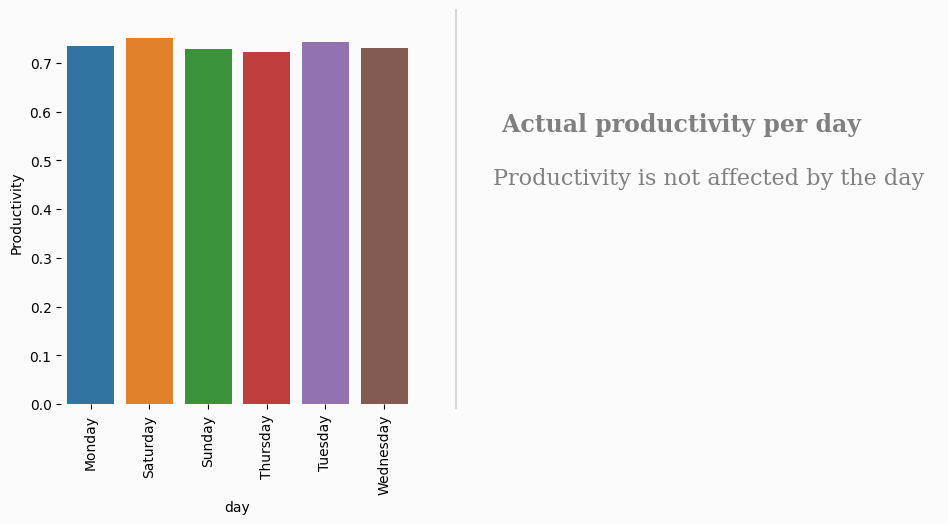

In [45]:
sns.reset_defaults()

#Visualization
fig=plt.figure(figsize=(10,5));

ax0=fig.add_subplot(1,2,1)
ax1=fig.add_subplot(1,2,2)
ax1.grid(False)
ax1.set_xticklabels([])
ax1.set_yticklabels([])

fig.patch.set_facecolor(background_color)
ax0.set_facecolor(background_color)
ax1.set_facecolor(background_color)
ax0.spines["bottom"].set_visible(False)
ax0.spines["top"].set_visible(False)
ax0.spines["right"].set_visible(False)
ax0.spines["left"].set_visible(False)
ax1.spines["bottom"].set_visible(False)
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.spines["left"].set_visible(False)
ax1.tick_params(left=False,bottom=False)

#Plot 
sns.barplot(data=result,x='day',y='actual_productivity',ax=ax0)
ax0.set_ylabel('Productivity')

#rotating the ticklabels in x axis
for tick in ax0.get_xticklabels():
    tick.set_rotation(90)
    
#Draw line in the middle    
l1= lines.Line2D([0.52,0.52],[0.1, 0.9],color='black',lw=0.2,transform=fig.transFigure)
fig.lines.extend([l1])

#heading content
fig.text(x=0.5,
        y=0.6,
        fontweight='bold',
        fontfamily='serif',
        fontsize=17,
        color='grey',
        s='''
        Actual productivity per day
        ''')
#text content
fig.text(x=0.5,
        y=0.5,
        fontweight='light',
        fontfamily='serif',
        fontsize=16,
        color='grey',
        s='''
        Productivity is not affected by the day  
        ''')
plt.show()

In [46]:
result=df_input.groupby('team').aggregate({'idle_men':'sum'})

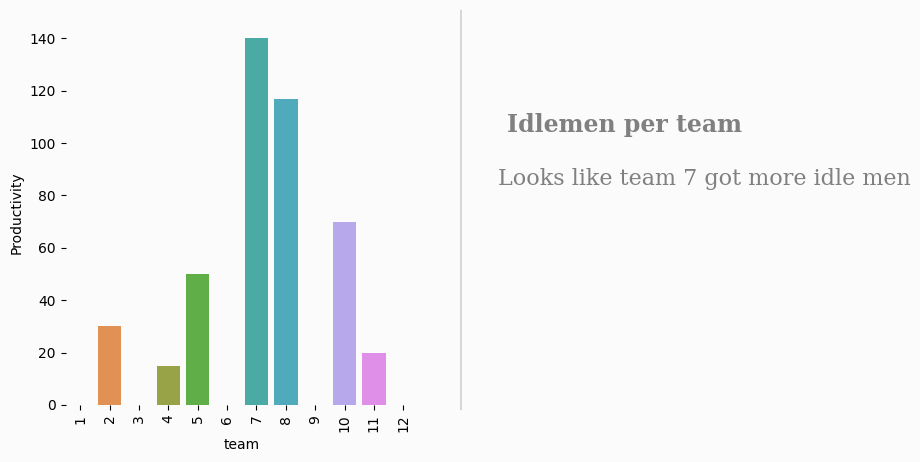

In [47]:
sns.reset_defaults()

#Visualization
fig=plt.figure(figsize=(10,5));

ax0=fig.add_subplot(1,2,1)
ax1=fig.add_subplot(1,2,2)
ax1.grid(False)
ax1.set_xticklabels([])
ax1.set_yticklabels([])

fig.patch.set_facecolor(background_color)
ax0.set_facecolor(background_color)
ax1.set_facecolor(background_color)
ax0.spines["bottom"].set_visible(False)
ax0.spines["top"].set_visible(False)
ax0.spines["right"].set_visible(False)
ax0.spines["left"].set_visible(False)
ax1.spines["bottom"].set_visible(False)
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.spines["left"].set_visible(False)
ax1.tick_params(left=False,bottom=False)

#Plot 
sns.barplot(data=result,x=result.index,y='idle_men',ax=ax0)
ax0.set_ylabel('Productivity')

#rotating the ticklabels in x axis
for tick in ax0.get_xticklabels():
    tick.set_rotation(90)
    
#Draw line in the middle    
l1= lines.Line2D([0.52,0.52],[0.1, 0.9],color='black',lw=0.2,transform=fig.transFigure)
fig.lines.extend([l1])

#heading content
fig.text(x=0.5,
        y=0.6,
        fontweight='bold',
        fontfamily='serif',
        fontsize=17,
        color='grey',
        s='''
        Idlemen per team
        ''')
#text content
fig.text(x=0.5,
        y=0.5,
        fontweight='light',
        fontfamily='serif',
        fontsize=16,
        color='grey',
        s='''
        Looks like team 7 got more idle men
        ''')
plt.show()

# **Data Wrangling**

In [49]:
df = df_input.copy()

In [50]:
df

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity,month,year
0,1,Quarter1,sweing,Thursday,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,0.940725,1,2015
1,1,Quarter1,finishing,Thursday,1,0.75,3.94,NaN,960,0,0.0,0,0,8.0,0.886500,1,2015
2,1,Quarter1,sweing,Thursday,11,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570,1,2015
3,1,Quarter1,sweing,Thursday,12,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570,1,2015
4,1,Quarter1,sweing,Thursday,6,0.80,25.90,1170.0,1920,50,0.0,0,0,56.0,0.800382,1,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1192,11,Quarter2,finishing,Wednesday,10,0.75,2.90,NaN,960,0,0.0,0,0,8.0,0.628333,3,2015
1193,11,Quarter2,finishing,Wednesday,8,0.70,3.90,NaN,960,0,0.0,0,0,8.0,0.625625,3,2015
1194,11,Quarter2,finishing,Wednesday,7,0.65,3.90,NaN,960,0,0.0,0,0,8.0,0.625625,3,2015
1195,11,Quarter2,finishing,Wednesday,9,0.75,2.90,NaN,1800,0,0.0,0,0,15.0,0.505889,3,2015


In [51]:
df.quarter.unique()

array(['Quarter1', 'Quarter2', 'Quarter3', 'Quarter4', 'Quarter5'],
      dtype=object)

In [52]:
# The year value 2015 is common across the dataset. Hence removing year.
df.drop('year',axis=1,inplace=True)

In [53]:
# Feature 'quarter' doesn't make any sense. This we can derive from date and month. Hence removing feature 'quarter'
df.drop('quarter',axis=1,inplace=True)

In [54]:
# About 57.72% wip feature containing null values. Hence removing this feature.
df.drop('wip',axis=1,inplace=True)

In [55]:
# actual_productivity is the target variable, having skewness -0.807
# Let's try to reduce this target feature skewness
log_target = np.log(df.actual_productivity)
sqrt_target = np.sqrt(df.actual_productivity)
boxcox_target = stats.boxcox(df_input.actual_productivity)

# Store the BoxCox key for getting the actual value
box_cox_param = boxcox_target[1]

boxcox_target = pd.Series(boxcox_target[0])
print (f"Log skewness: {log_target.skew()}\nSquare root target skewness : {sqrt_target.skew()}\nBoxcox target skewness: {boxcox_target.skew()}")


Log skewness: -1.5736961147100366
Square root target skewness : -1.1734572168685393
Boxcox target skewness: -0.13866501140801019


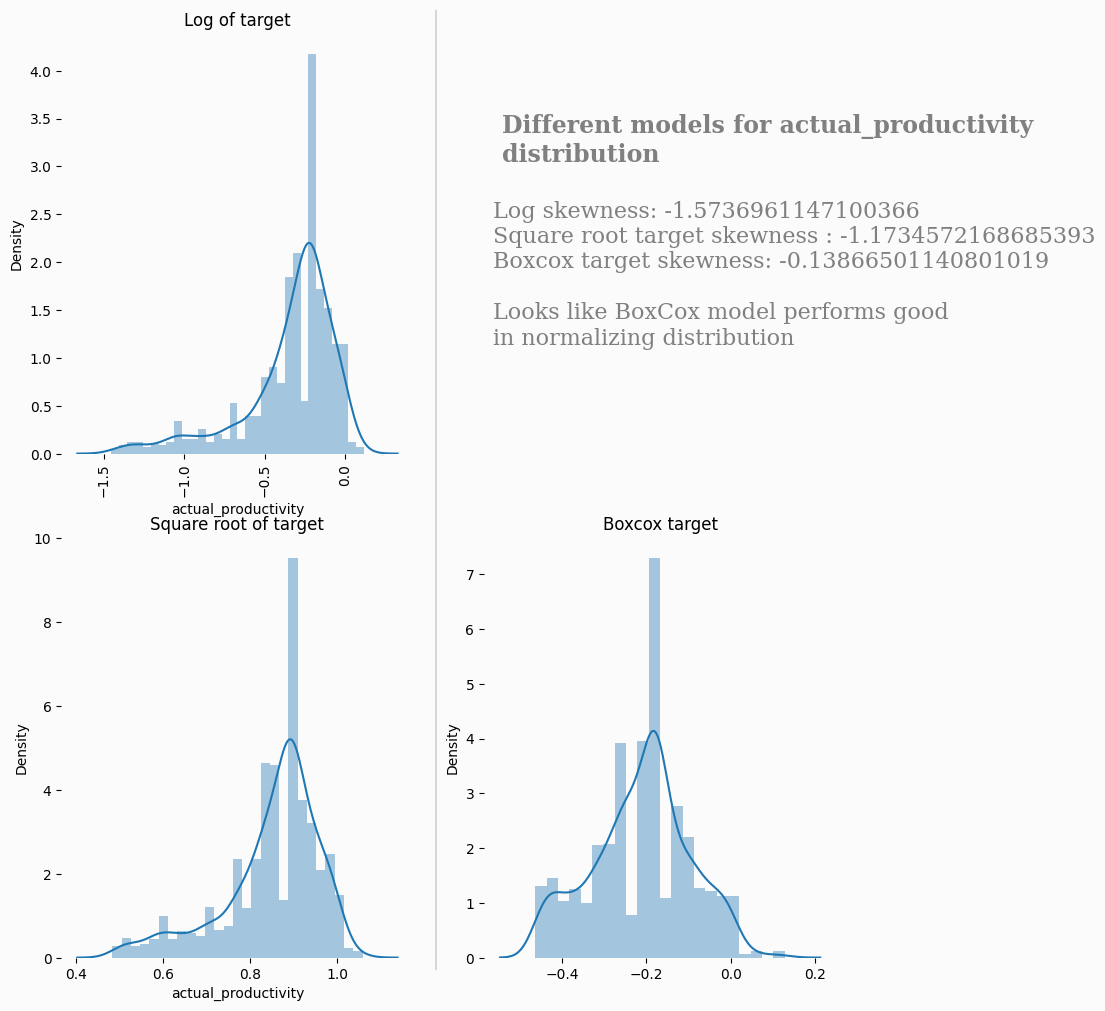

In [56]:
sns.reset_defaults()

#Visualization
fig=plt.figure(figsize=(10,12));

ax0=fig.add_subplot(2,2,1)
# ax1=fig.add_subplot(2,2,2)
ax2=fig.add_subplot(2,2,3)
ax3=fig.add_subplot(2,2,4)

#ax1.grid(False)
#ax1.set_xticklabels([])
#ax1.set_yticklabels([])

fig.patch.set_facecolor(background_color)

ax0.set_facecolor(background_color)
#ax1.set_facecolor(background_color)
ax2.set_facecolor(background_color)
ax3.set_facecolor(background_color)

for side in ["bottom","top","right","left"]:
    ax0.spines[side].set_visible(False)
#    ax1.spines[side].set_visible(False)
    ax2.spines[side].set_visible(False)
    ax3.spines[side].set_visible(False)

#Plot 
sns.distplot(log_target,ax=ax0)
ax0.set_title("Log of target")

sns.distplot(sqrt_target,ax=ax2)
ax2.set_title("Square root of target")

sns.distplot(boxcox_target,ax=ax3)
ax3.set_title("Boxcox target")

#rotating the ticklabels in x axis
for tick in ax0.get_xticklabels():
    tick.set_rotation(90)
    
#Draw line in the middle    
l1= lines.Line2D([0.5,0.5],[0.1, 0.9],color='black',lw=0.2,transform=fig.transFigure)
fig.lines.extend([l1])

#heading content
fig.text(x=0.5,
        y=0.75,
        fontweight='bold',
        fontfamily='serif',
        fontsize=17,
        color='grey',
        s='''
        Different models for actual_productivity
        distribution
        ''')
#text content
fig.text(x=0.5,
        y=0.6,
        fontweight='light',
        fontfamily='serif',
        fontsize=16,
        color='grey',
        s='''
        Log skewness: -1.5736961147100366
        Square root target skewness : -1.1734572168685393
        Boxcox target skewness: -0.13866501140801019
        
        Looks like BoxCox model performs good 
        in normalizing distribution
        ''')
plt.show()

In [57]:
# Replacing taget feature with Boxcox transformed target
df['actual_productivity']=boxcox_target

In [58]:
# Since department is categorical feature, applying onehot encoding to 'department'
df=pd.concat([df,pd.get_dummies(df['department'])],axis=1)
df.drop('department',axis=1,inplace=True)

In [59]:
# Feature 'team' also categorical feature
df=pd.concat([df,pd.get_dummies(df['team'],prefix='team')],axis=1)
df.drop('team',axis=1,inplace=True)

In [60]:
# Feature 'day' is categorical in nature
df=pd.concat([df,pd.get_dummies(df['day'])],axis=1)
df.drop('day',axis=1,inplace=True)

In [61]:
# Dropping the feature 'date'
df.drop('date',axis=1,inplace=True)

In [62]:
print (f"Feature names after data wrangling :\n\n {df.columns}")

Feature names after data wrangling :

 Index(['targeted_productivity', 'smv', 'over_time', 'incentive', 'idle_time',
       'idle_men', 'no_of_style_change', 'no_of_workers',
       'actual_productivity', 'month', 'finishing', 'sweing', 'team_1',
       'team_2', 'team_3', 'team_4', 'team_5', 'team_6', 'team_7', 'team_8',
       'team_9', 'team_10', 'team_11', 'team_12', 'Monday', 'Saturday',
       'Sunday', 'Thursday', 'Tuesday', 'Wednesday'],
      dtype='object')


In [64]:
# Let's check the correlation of features with target feature.
df_corr = df.copy()
correlation_matrix = df_corr.corr()
# Interested only in the relation with target feature 'actual_productivity'
correlation_matrix=correlation_matrix['actual_productivity']
correlation_matrix=correlation_matrix.to_frame()
correlation_matrix.sort_values(by='actual_productivity',ascending=False,inplace=True)
display(correlation_matrix)

,actual_productivity
actual_productivity,1.000000
targeted_productivity,0.403203
team_1,0.167696
finishing,0.128706
team_3,0.119069
team_2,0.081117
incentive,0.074753
team_12,0.064724
team_4,0.060815
Saturday,0.046709


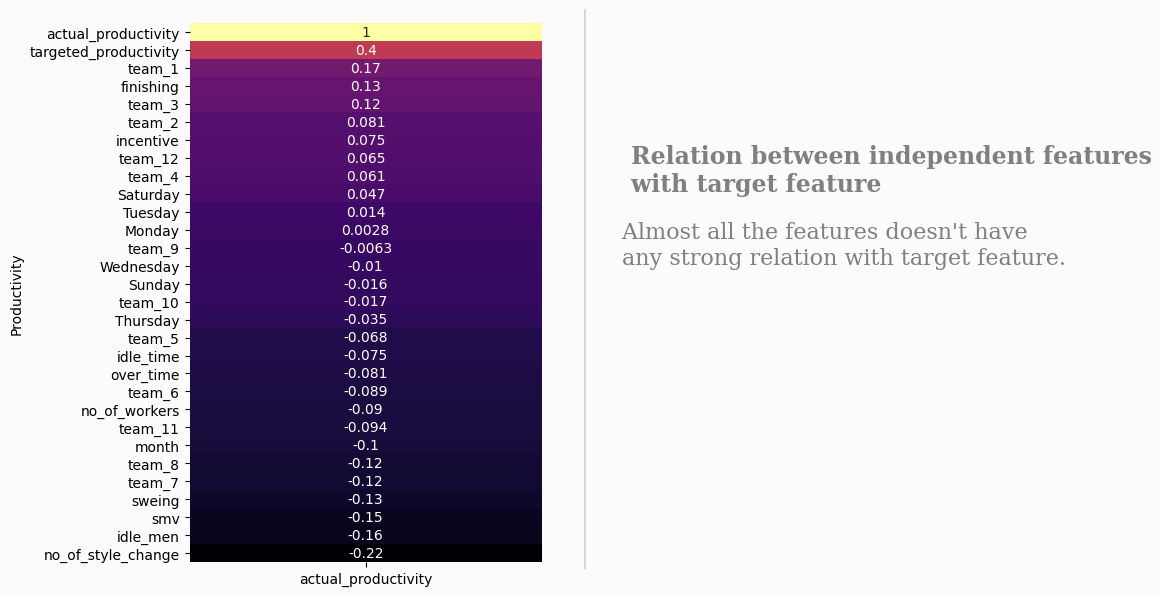

In [65]:
sns.reset_defaults()

#Visualization
fig=plt.figure(figsize=(10,7));

ax0=fig.add_subplot(1,2,1)
ax1=fig.add_subplot(1,2,2)
ax1.grid(False)
ax1.set_xticklabels([])
ax1.set_yticklabels([])

fig.patch.set_facecolor(background_color)
ax0.set_facecolor(background_color)
ax1.set_facecolor(background_color)
ax0.spines["bottom"].set_visible(False)
ax0.spines["top"].set_visible(False)
ax0.spines["right"].set_visible(False)
ax0.spines["left"].set_visible(False)
ax1.spines["bottom"].set_visible(False)
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.spines["left"].set_visible(False)
ax1.tick_params(left=False,bottom=False)

#Plot 
sns.heatmap(correlation_matrix,cmap='inferno',annot=True,cbar=False,ax=ax0)
ax0.set_ylabel('Productivity')

   
#Draw line in the middle    
l1= lines.Line2D([0.52,0.52],[0.1, 0.9],color='black',lw=0.2,transform=fig.transFigure)
fig.lines.extend([l1])

#heading content
fig.text(x=0.5,
        y=0.6,
        fontweight='bold',
        fontfamily='serif',
        fontsize=17,
        color='grey',
        s='''
        Relation between independent features
        with target feature
        ''')
#text content
fig.text(x=0.5,
        y=0.5,
        fontweight='light',
        fontfamily='serif',
        fontsize=16,
        color='grey',
        s='''
        Almost all the features doesn't have 
        any strong relation with target feature.
        ''')
plt.show()

# **Model training**

In [66]:
# Function for providing generalized results for regression model
def evaluate_model(model,x_train,y_train,x_test,y_test):
    '''
    Inputs
    1. regression model eg: LinearRegression(),LassoRegression() etc.
    2. training x data
    3. training y data
    4. testing x data
    5. testing y data
    '''
    model.fit(x_train,y_train)
    model_name=model.__class__.__name__
    
    train_score=model.score(x_train,y_train)
    test_score=model.score(x_test,y_test)
    print (f"Training score: {train_score}\nTesting score: {test_score}")
    
    y_pred=model.predict(x_test)
    print("Prediction completed.")
    df=pd.DataFrame({"Actual": y_test,
                     "Predicted":y_pred})
    
    #Apply inverse box cox to retrieve original target results
    df=inv_boxcox(df,box_cox_param)
    
    #Finding the difference between original and predicted
    df["difference"]=df.Predicted-df.Actual
    df.reset_index(inplace=True)
    
    #Plot actual vs predicted
    plt.figure(figsize=(10,5));
    sns.scatterplot(data=df,x="index",y="Actual",color='grey',label=["Actual"]).set_facecolor(background_color);
    sns.lineplot(data=df,x="index",y="Predicted",color='salmon',label=["Predicted"]);
    plt.legend(loc="right",bbox_to_anchor=(1.1,1));
    plt.title(model_name+" -Actual vs Predicted");
    plt.show()
    
    print ("Sample comparison file for actual and predicted target feature:")
    display(df.head())
    
    # Return the model for re-use if required.
    return model

In [67]:
#General data frame and function for storing and comparing model results.
df_model_results=pd.DataFrame(columns=["ModelName","TrainScore"])

def store_model_results(modl_name,train_score):
    global df_model_results
    row_loc=df_model_results.shape[0]+1
    df_model_results.loc[row_loc,["ModelName","TrainScore"]]=[modl_name,train_score]

In [68]:
#Run each model and show the combined results.
def show_model_scores(x,y):
    global df_model_results
    df_model_results=df_model_results.iloc[0:0] #reset display dataframe
    for model in  [LinearRegression(),
                   Lasso(),
                   Ridge(),
                   ElasticNet(),
                   XGBRegressor()]:
        store_model_results(model.__class__.__name__, cross_val_score(model,x,y,cv=3).mean())
    df_model_results.sort_values("TrainScore",ascending=False,inplace=True)
    display(df_model_results)
    display(HTML('Selected model : <b>' + df_model_results.head(1)['ModelName'].values[0] + '</b>'))
    

In [69]:
# Setting dependent and independent variables
y = df.actual_productivity
x = df.drop('actual_productivity',axis=1)

In [70]:
# Set training and testing dataset
x_train,x_test,y_train,y_test=train_test_split(x,y)

In [71]:
#Lets run the 
show_model_scores(x_train,y_train)

[05:36:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:36:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:36:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,ModelName,TrainScore
5,XGBRegressor,0.472584
1,LinearRegression,0.258248
3,Ridge,0.25524
2,Lasso,0.00085112
4,ElasticNet,-0.000418094


[05:36:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training score: 0.6594077317714939
Testing score: 0.49417970418752843
Prediction completed.


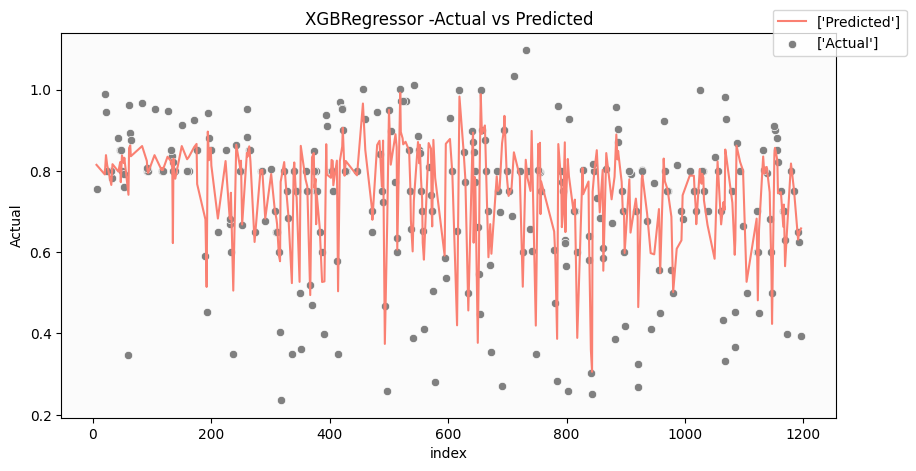

Sample comparison file for actual and predicted target feature:


,index,Actual,Predicted,difference
0,1155,0.880754,0.833689,-0.047065
1,310,0.650417,0.680849,0.030432
2,116,0.800344,0.801752,0.001408
3,49,0.800319,0.838147,0.037829
4,339,0.800129,0.802900,0.002771


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [72]:
evaluate_model(XGBRegressor(),x_train,y_train,x_test,y_test)

# **Model tunning**

In [73]:
# Possible parameter values
param_tuning={
    'learning_rate' : [0.01,0.1,.11,.2],
    'max_depth' : [1,2,3,5],
    'min_child_weight' : [3,5,7,9],
    'subsample' : [0.5,0.7,0.9],
    'colsample_bytree' : [0.3,0.5,0.7,0.9],
    'n_estimators' : [25,50,100],
    'objective' : ['reg:squarederror']
}

In [74]:
# Using the GridSearchCrossValidation, find the model with best parameter settings
gsearch = GridSearchCV (estimator = XGBRegressor(),
                       param_grid = param_tuning,
                       cv = 2,
                       n_jobs= -1,
                       verbose = 1)

In [75]:
# Not that below step may be time consuming process.
# gsearch.fit(x,y)
# print (gsearch.best_params_)

# Below is the best parameters for the model, obtained from gsearch.best_params
best_params = {'colsample_bytree': 0.7, 'learning_rate': 0.11, 'max_depth': 3, 'min_child_weight': 7, 'n_estimators': 50, 'objective': 'reg:squarederror', 'subsample': 0.7}

In [76]:
# Save the model with best parameters
# selected_model = gsearch.best_estimator_

selected_model = XGBRegressor(colsample_bytree=0.7, learning_rate=0.11, max_depth=3,
             min_child_weight=7, n_estimators=50, objective='reg:squarederror', subsample=0.7)

Training score: 0.5937083668852681
Testing score: 0.4850891872758222
Prediction completed.


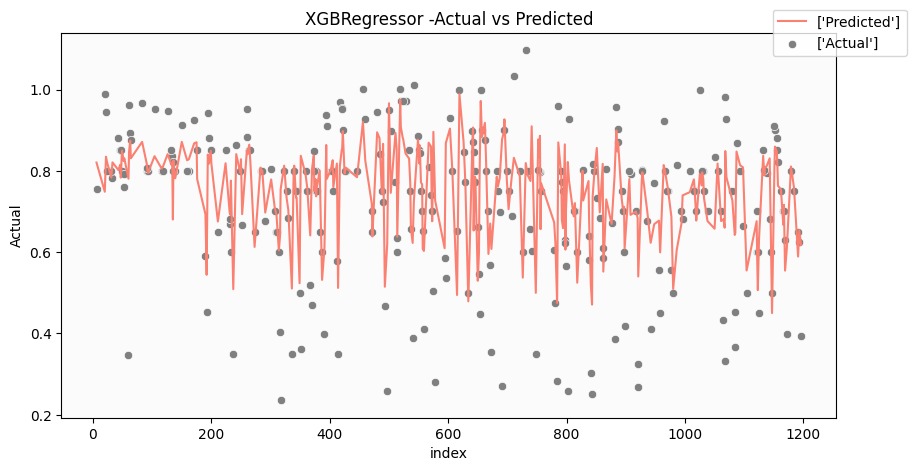

Sample comparison file for actual and predicted target feature:


,index,Actual,Predicted,difference
0,1155,0.880754,0.847869,-0.032885
1,310,0.650417,0.691634,0.041217
2,116,0.800344,0.805644,0.005300
3,49,0.800319,0.849802,0.049483
4,339,0.800129,0.800757,0.000628


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0,
             importance_type='gain', learning_rate=0.11, max_delta_step=0,
             max_depth=3, min_child_weight=7, missing=None, n_estimators=50,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=0.7, verbosity=1)

In [77]:
# Find how the model is performing now.
evaluate_model(selected_model,x_train,y_train,x_test,y_test)